# Template Search

Given a template image (e.g. `./anchor.png`), can we detect this in the video footage?

![Example template](./anchor.png)

In [5]:
import cv2
import os
import numpy as np 
import os
import shutil
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

## Part 1: Getting all trial directories

In [10]:
def get_deepest_subdirs(root_dir, exclusions=None):
    deepest = set()
    for dirpath, dirnames, filenames in os.walk(root_dir):
        dirnames[:] = [d for d in dirnames if d not in exclusions]
        if not dirnames:
            # Ensure THIS directory itself is not excluded
            if os.path.basename(dirpath) not in exclusions:
                deepest.add(dirpath)
    return list(deepest)

def mkdirs(_DIR:str, delete_existing:bool=True):
    # If the folder already exists, delete it
    if delete_existing and os.path.exists(_DIR): shutil.rmtree(_DIR)
    # Create a new empty directory
    os.makedirs(_DIR, exist_ok=True)
    # Return the directory to indicate completion
    return _DIR

def get_trial_dirs(root_dir:str, verbose:bool=False):
    trial_dirs = get_deepest_subdirs(root_dir, ['frames', 'anchor_frames', 'estimation_frames', 'validations'])
    if verbose: display(trial_dirs)
    return trial_dirs

In [11]:
trial_dirs = get_trial_dirs(os.path.join('.','captures'), verbose=True)

['./captures/mq2/58-no-pc_ver',
 './captures/mq2/58-yes-android',
 './captures/mq2/68-yes-pc_ver',
 './captures/mq2/68-yes-pc_hor',
 './captures/mq2/58-no-android',
 './captures/mq2/68-no-iphone',
 './captures/mq2/68-yes-iphone',
 './captures/mq2/58-yes-mac',
 './captures/mq2/68-yes-mac',
 './captures/mq2/68-no-android',
 './captures/mq2/58-no-mac',
 './captures/mq2/68-no-pc_ver',
 './captures/mq2/58-no-iphone',
 './captures/mq3/63-no-android',
 './captures/mq2/68-no-pc_hor',
 './captures/mq2/58-no-pc_hor-2',
 './captures/mq2/58-yes-pc_ver',
 './captures/mq2/68-yes-android',
 './captures/mq2/58-yes-pc_hor',
 './captures/mq2/58-yes-iphone',
 './captures/mq2/68-no-mac',
 './captures/mq2/58-no-pc_hor']

## Part 2: Extracting Frames from Videos

Each trial directory is expected to have the following files:

- `gaze_targets.csv`: The positions (both world and screen, for each left, center, or right eye) of each gaze target
- `events.csv`: Timestamps of the appearances of each gaze target during calibration
- `video.mp4` or `video.mov`: video files.

When we extract frames, we need to do the following:

1. Join `gaze_targets.csv` and `events.csv` to represent each gaze target's position.
2. Using the timestamps, extract the frame for each calibration target. We also extract the last frame.

In [12]:
def find_files_with_extensions(dir:str, extensions):
    found_files = []
    for root, _, files in os.walk(dir):
        for file in files:
            _, ext = os.path.splitext(file)
            if ext.lower() in [e.lower() for e in extensions]:  # Case-insensitive comparison
                found_files.append(os.path.join(root, file))
    return found_files

class Frame:
    def __init__(self, target_number, filepath, frame, width, height, left_screen, center_screen, right_screen):
        # Core info
        self.target_number = target_number
        self.filepath = filepath
        self.frame = frame
        self.width = width
        self.height = height

        # Mappings
        self.left = left_screen
        self.center = center_screen
        self.right = right_screen

        # Template Matching
        self.template_bboxes = None
        self.mean_centroid = None
        self.median_centroid = None
        self.transformation_matrix = None

    def getScreenFromVR(self, query_coords):
        assert self.transformation_matrix is not None, "Cannot get screen coordinates without a transformation matrix"
        return np.dot(query_coords, self.transformation_matrix)
    
    def drawBBoxes(self, frame=None, bbox_color=[0,255,255], bbox_thickness=1, draw_centroids:bool=True, centroids_color=[0,255,255]):
        assert self.template_bboxes is not None, "Cannot draw bboxes that don't exist"
        outframe = self.frame.copy() if frame is None else frame.copy()
        for (x1, y1, x2, y2, cx, cy) in self.template_bboxes:
            outframe = cv2.rectangle(outframe, (x1, y1), (x2, y2), bbox_color, bbox_thickness)
            if draw_centroids:
                outframe = cv2.drawMarker(outframe, (int(cx), int(cy)), centroids_color, cv2.MARKER_CROSS, 20, 2)
        return outframe, self.template_bboxes

    def drawMeanCentroid(self, frame=None, centroid_color=[255,255,0]):
        assert self.template_bboxes is not None, "Cannot draw mean centroid from bboxes that don't exist"
        outframe = self.frame.copy() if frame is None else frame.copy()
        center = np.mean([[cx,cy] for (x1, y1, x2, y2, cx, cy) in self.template_bboxes], axis=0)
        outframe = cv2.drawMarker(outframe, (int(center[0]), int(center[1])), centroid_color, cv2.MARKER_CROSS,20,2)
        self.mean_centroid = center
        return outframe
    
    def drawMedianCentroid(self, frame=None, centroid_color=[0,0,0]):
        assert self.template_bboxes is not None, "Cannot draw mean centroid from bboxes that don't exist"
        outframe = self.frame.copy() if frame is None else frame.copy()
        center = np.median([[cx,cy] for (x1, y1, x2, y2, cx, cy) in self.template_bboxes], axis=0)
        outframe = cv2.drawMarker(outframe, (int(center[0]), int(center[1])), centroid_color, cv2.MARKER_TILTED_CROSS,20,2)
        self.median_centroid = center
        return outframe

In [13]:
# Initialize
trials = []
timestamp_offset = 2.0

# Iterate through each trial. Use TQDM for visual feedback
pbar = tqdm(trial_dirs)
for root_dir in pbar:

    # Update progress bar description
    pbar.set_description(f"Extracting frames from \"{root_dir}\"")
    
    # Define filepaths
    events_filepath = os.path.join(root_dir, 'events.csv')
    targets_filepath = os.path.join(root_dir, 'gaze_targets.csv')
    frames_dir = os.path.join(root_dir, 'frames')

    # Extract csv files. Exit early if these don't exist
    events_df = pd.read_csv(events_filepath)
    targets_df = pd.read_csv(targets_filepath)

    # Filter out `Start` and `End` rows in `events_df`
    edf = events_df[~events_df['event'].isin(['Start','End'])]
    edf["target_number"] = edf["target_number"].astype(int)

    # Modify `targets_df` to rmeove `unix_ms` and typecast `target_number` as integer
    tdf = targets_df.drop(columns=['unix_ms'])
    tdf["target_number"] = tdf["target_number"].astype(int)
    
    # Inner Join on `edf` with `targets_df`
    df = pd.merge(left=edf, right=tdf, left_on='target_number', right_on='target_number')

    # Pre-emptively create `frames` directory
    os.makedirs(frames_dir, exist_ok=True)

    # Find `video` file in the root directory
    videos = find_files_with_extensions(root_dir, ['.mov','.mp4'])
    if len(videos) == 0:
        print(f"There are no video files in subdirectory \"{root_dir}\"")
        continue
    video_filename = videos[0]
    
    # Initialize 
    cap = cv2.VideoCapture(video_filename)

    if not cap.isOpened():
        print(f"Could not open video \"{video_filename}\"")
        continue
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames = []

    # Iterate through all frames
    for index, row in df.iterrows():
        target_time = row['timestamp'] + timestamp_offset
        frame_idx = int(target_time * fps)
        
        # Get screen position for each eye
        left_screen = (row['screen_left_pos_x'], row['screen_left_pos_y'])
        center_screen = (row['screen_center_pos_x'], row['screen_center_pos_y'])
        right_screen = (row['screen_right_pos_x'], row['screen_right_pos_y'])

        # Seek to the desired frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read frame, move to next row if unable to read frame
        ok, frame = cap.read()
        if not ok:  
            print(f"Warning: Unable to read frame at {target_time}s (frame {frame_idx}).")
            continue
        frames.append(Frame(
            row['target_number'], 
            os.path.join(frames_dir, f"{row['target_number']}.jpg"), 
            frame,
            width,
            height,
            left_screen,
            center_screen,
            right_screen
        ))

    # Release capture
    cap.release()

    # Print each frame, if they exist
    if len(frames) == 0:
        print("No frames detected!")
        continue
    mkdirs(frames_dir)
    for f in frames:
        cv2.imwrite(f.filepath, f.frame)

    # Add to trial
    trials.append({
        'root_dir': root_dir,
        'frames': frames
    })


Extracting frames from "./captures/mq2/58-no-pc_hor": 100%|██████████| 22/22 [00:09<00:00,  2.37it/s]  


## Part 3: Template Matching

In [14]:
def estimate_template_from_image(
        src_img, 
        template_img, 
        min_size=10, 
        max_size=50, 
        delta_size=5, 
        thresh=0.9, 
        verbose=True):
    
    # Initialize bounding boxes
    bboxes = []

    # Iterate through possible sizes of the template, upwards to half of the size
    for p in np.arange(min_size, max_size, delta_size):
        
        # Resize the frame
        template_resize = cv2.resize(template_img, (p,p))
       
        # Get particular attributes of the image itself. 
        # We assume transparency, so we have to separate alpha from bgr
        template = template_resize[:,:,0:3]
        alpha = template_resize[:,:,3]
        alpha = cv2.merge([alpha,alpha,alpha])
        
        # get the width and height of the template
        h,w = template.shape[:2]
        
        # Prepare possible locations where the template matches
        loc = []
        
        # Find those matches.
        res = cv2.matchTemplate(src_img, template, cv2.TM_CCORR_NORMED, mask=alpha)

        # threshold
        loc = np.where(res >= thresh)
        if len(loc) > 0:
            for pt in zip(*loc[::-1]):
                bboxes.append((pt[0],pt[1],pt[0]+w,pt[1]+h, pt[0]+(w/2), pt[1]+(h/2)))
    
    # Print and return
    if verbose: print(f"# Detected Bounding Boxes: {len(bboxes)}")
    return bboxes

In [15]:
# Use OpenCV to read anchor image
anchor_filepath = './anchor.png'
anchor_img = cv2.imread(anchor_filepath, cv2.IMREAD_UNCHANGED)

# Initialize
estimations = []

# Iterate through each trial. Use TQDM for visual feedback
pbar = tqdm(trials)
for trial in pbar:

    # Update progress bar description
    pbar.set_description(f"Estimating anchors from frames in \"{trial['root_dir']}\"")

    # Generate output directory for drawn images
    outdir = mkdirs(os.path.join(trial['root_dir'], 'anchor_frames'))

    # Iterate through frames
    #for f in frames:
    #    cv2.imwrite(f.filepath, f.frame)

    # For each frame, attempt to estimate the anchor
    for frame in trial['frames']:

        # Estimate
        frame.template_bboxes = estimate_template_from_image(frame.frame, anchor_img, verbose=False)
        
        # Draw
        mean_centroid_frame = frame.drawMeanCentroid()
        median_centroid_frame = frame.drawMedianCentroid(frame=mean_centroid_frame)

        # Render
        cv2.imwrite(os.path.join(outdir, f"{frame.target_number}.jpg"), median_centroid_frame)

Estimating anchors from frames in "./captures/mq2/58-no-pc_hor": 100%|██████████| 22/22 [08:56<00:00, 24.38s/it]  


## Part 4: Identifying Screen Mappings

The centroids detected with template matching above are relative to the top-left corner. Unity's `WorldToScreenPoint` is relative to the bottom-left. However, that doesn't matter, because our transformation matrix can handle this in theory.

For all intents and purposes, let's use the median center.

That being said, we now have a mapping: the median center (corrected to be bottom-left) and the screen position of the target (let's exclude `all`). We can leverage `numpy.linalg.lstsq` (least squares approximation) for that.

We would have to generate a new transformation matrix for each method of recording, but that's not too much of a hassle.

In [16]:
def to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [to_serializable(i) for i in obj]
    else:
        return obj

# Iterate through each trial. Use TQDM for visual feedback
pbar = tqdm(trials)
for trial in pbar:

    # Initialize coords arrays
    vr_coords = []
    img_coords = []

    # Iterate each frame
    for frame in trial['frames']:
        # Append the coords for VR coords
        vr_coords.append(frame.center)
        # Append coords for the median centroid
        img_coords.append(frame.median_centroid)

    # Append a new `1` value, then derive the transformation matrix.
    A = np.vstack([np.array(vr_coords).T, np.ones(len(trial['frames']))]).T
    transformation_matrix, res, rank, s = np.linalg.lstsq(A, img_coords, rcond=None)

    # Save the transformation matrix 
    output = {
        'vr_anchors_positions':to_serializable(vr_coords),
        'img_anchors_positions':to_serializable(img_coords),
        'transformation_matrix':to_serializable(transformation_matrix)
    }
    with open(os.path.join(trial['root_dir'], 'transformations.json'), "w") as outfile: 
        json.dump(output, outfile, indent=2)

    print(np.linalg.norm(transformation_matrix))

    # Apply transformation matrix to each frame
    for frame in trial['frames']:
        frame.transformation_matrix = transformation_matrix

100%|██████████| 22/22 [00:00<00:00, 3049.70it/s]

1669.0137334675924
2471.0944685507634
1586.213384853066
1672.4689339498452
2470.408836596811
1100.5680800605915
1100.5682466849573
3001.725623752208
2765.1231887326335
2264.2245383498284
3001.6761208988464
1585.6089984398022
1200.8453319393761
2502.1977721202425
1672.468960453554
1794.619684623439
1669.7930634276092
2264.1561523238865
1798.5956018248794
1200.8451900476118
2765.3913420067242
1798.0461824411618


To apply the transformation matrix, let's attempt to calculate the screen positions FROM vr coordinates

In [17]:
# Iterate through each trial. Use TQDM for visual feedback
pbar = tqdm(trials)
for trial in pbar:

    # Generate output directory for drawn images
    outdir = mkdirs(os.path.join(trial['root_dir'], 'estimation_frames'))
    
    # Iterate each frame
    for frame in trial['frames']:
        
        # Get the vr frames for the center screen
        center_coords = [frame.center[0], frame.center[1], 1]
        # Apply the transformation
        corrected_center_coords = frame.getScreenFromVR(center_coords)
        #corrected_center_coords[1] = frame.height - corrected_center_coords[1]

        # Draw
        outframe = frame.frame.copy()
        outframe = cv2.drawMarker(outframe, (int(frame.median_centroid[0]), int(frame.median_centroid[1])), [225,255,0], cv2.MARKER_DIAMOND,20,2)
        outframe = cv2.drawMarker(outframe, (int(center_coords[0]), int(center_coords[1])), [255,255,0], cv2.MARKER_CROSS,20,2)
        outframe = cv2.drawMarker(outframe, (int(corrected_center_coords[0]), int(corrected_center_coords[1])), [0,0,0], cv2.MARKER_TILTED_CROSS,20,2)

        # Render
        cv2.imwrite(os.path.join(outdir, f"{frame.target_number}.jpg"), outframe)




100%|██████████| 22/22 [00:01<00:00, 19.37it/s]


## Part 5: Differences Between Transformation Matrices

Are there any differences between the transformation matrices in of themselves? In theory, there should be... but we won't know. Let's find out.

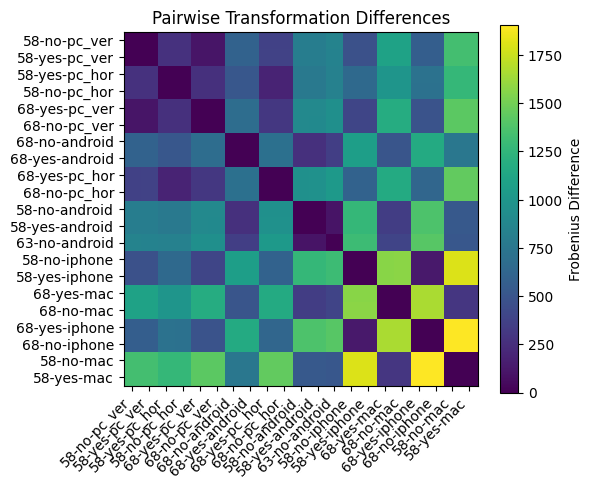

In [18]:
# This is a pairwise Frobenius norm difference between our transformation matrices
def build_distance_matrix(objects):
    """
    objects: list of dicts with 'name' and 'transformation_matrix'
    returns: (distance_matrix, names_list)
    """
    names = [obj["name"] for obj in objects]
    n = len(objects)
    dist = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            A = objects[i]["transformation_matrix"]
            B = objects[j]["transformation_matrix"]
            dist[i, j] = np.linalg.norm(A - B)  # Frobenius

    return dist, names

# We plot the distances in a heatmap
def plot_distance_heatmap(dist_matrix, names):
    plt.figure(figsize=(6, 5))
    plt.imshow(dist_matrix)
    plt.colorbar(label="Frobenius Difference")

    # Add labels
    plt.xticks(ticks=np.arange(len(names)), labels=names, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(names)), labels=names)

    plt.title("Pairwise Transformation Differences")
    plt.tight_layout()
    plt.show()

# Sorting to make the visualization easier
def sort_by_total_difference(dist_matrix, names):
    totals = dist_matrix.sum(axis=1)
    order = np.argsort(totals)  # least → greatest total distance

    sorted_dist = dist_matrix[order][:, order]
    sorted_names = [names[i] for i in order]
    
    return sorted_dist, sorted_names

# All transformation matrices are stored in each frame. 
# We can also technically get them from each trial directory, which should contain a `transformations.json` file

transformation_matrices = []
for trial_dir in trial_dirs:
    tname = os.path.basename(os.path.normpath(trial_dir))
    if tname == '58-no-pc_hor-2': continue
    inpath = os.path.join(trial_dir, 'transformations.json')
    if os.path.exists(inpath):
        with open(inpath, 'r') as f:
            tdata = json.load(f)
            if 'transformation_matrix' in tdata:
                transformation_matrices.append({
                    'name':tname, 
                    'transformation_matrix':np.array(tdata['transformation_matrix'])
                })

# Now we can measure the pairwise differences between each condition
dist_matrix, names = build_distance_matrix(transformation_matrices)

# We sort for easier visualization
sorted_matrix, sorted_names = sort_by_total_difference(dist_matrix, names)

# Now we plot
plot_distance_heatmap(sorted_matrix, sorted_names)


How about a Hierarchical Clustering, similar to gene expression heatmaps?

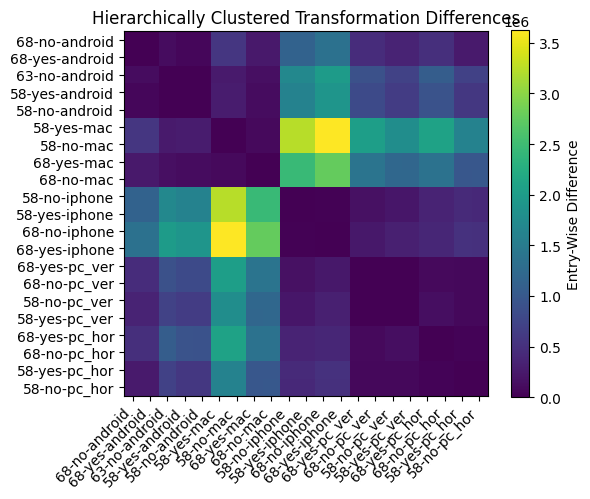

In [19]:
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

def build_distance_matrix(objects, diff_op:str='Frobenius'):
    names = [obj["name"] for obj in objects]
    n = len(objects)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A = objects[i]["transformation_matrix"]
            B = objects[j]["transformation_matrix"]
            if diff_op == 'Frobenius':
                dist[i, j] = np.linalg.norm(A - B)
            elif diff_op == 'Entry-Wise':
                dist[i, j] = np.sum((A - B)**2)
    return dist, names

def hierarchical_sort(dist_matrix):
    # SciPy expects a condensed form → convert NxN to 1D
    condensed = squareform(dist_matrix, checks=False)
    # perform hierarchical clustering
    Z = linkage(condensed, method="average")
    # extract leaf order → this is the new sorted order
    order = leaves_list(Z)
    return order

def reorder(dist_matrix, names, order):
    sorted_matrix = dist_matrix[order][:, order]
    sorted_names = [names[i] for i in order]
    return sorted_matrix, sorted_names

def plot_heatmap(dist_matrix, names, diff_op:str='Frobenius'):
    plt.figure(figsize=(6, 5))
    plt.imshow(dist_matrix)
    plt.colorbar(label=f"{diff_op} Difference")
    plt.xticks(ticks=np.arange(len(names)), labels=names, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(names)), labels=names)
    plt.title("Hierarchically Clustered Transformation Differences")
    plt.tight_layout()
    plt.show()

diff_op='Entry-Wise'
dist_matrix, names = build_distance_matrix(transformation_matrices, diff_op=diff_op)
order = hierarchical_sort(dist_matrix)
sorted_matrix, sorted_names = reorder(dist_matrix, names, order)
plot_heatmap(sorted_matrix, sorted_names, diff_op=diff_op)


What if we divided between the different conditions?

In [20]:
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from collections import defaultdict

def parse_name(name):
    """
    Input example: '060-high-iphone'
    Output:
        { 'ipd': '060', 'resolution': 'high', 'device': 'iphone' }
    """
    parts = name.lower().split('-')

    ipd = parts[0] if len(parts) > 0 else "unknown"
    resolution = parts[1] if len(parts) > 1 else "unknown"
    device = parts[2] if len(parts) > 2 else "unknown"

    return {
        "ipd": ipd,
        "resolution": resolution,
        "device": device
    }

def build_distance_matrix(objects):
    names = [obj["name"] for obj in objects]
    n = len(objects)
    dist = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            A = objects[i]["transformation_matrix"]
            B = objects[j]["transformation_matrix"]
            dist[i, j] = np.linalg.norm(A - B)
    return dist, names

def hierarchical_order(dist_matrix):
    condensed = squareform(dist_matrix, checks=False)
    Z = linkage(condensed, method="average")
    return leaves_list(Z)

def grouped_hierarchical_sort(dist_matrix, names, group_by):

    parsed = [parse_name(n) for n in names]

    # Build mapping from group → list of indices
    groups = defaultdict(list)
    for idx, p in enumerate(parsed):
        key = tuple(p[field] for field in group_by)
        groups[key].append(idx)

    # Sort group keys alphabetically for deterministic ordering
    ordered_group_keys = sorted(groups.keys())

    final_order = []

    for key in ordered_group_keys:
        idxs = groups[key]

        # Submatrix for this group
        sub = dist_matrix[np.ix_(idxs, idxs)]

        if len(idxs) > 1:
            # Hierarchical clustering within group
            sub_order = hierarchical_order(sub)
            sorted_sub = [idxs[i] for i in sub_order]
        else:
            sorted_sub = idxs

        final_order.extend(sorted_sub)

    return final_order

def reorder(dist_matrix, names, order):
    sorted_matrix = dist_matrix[order][:, order]
    sorted_names = [names[i] for i in order]
    return sorted_matrix, sorted_names

def plot_heatmap(dist_matrix, names, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(dist_matrix)
    plt.colorbar(label="Frobenius Difference")

    plt.xticks(range(len(names)), names, rotation=45, ha="right")
    plt.yticks(range(len(names)), names)
    plt.title(title)
    plt.tight_layout()
    plt.show()

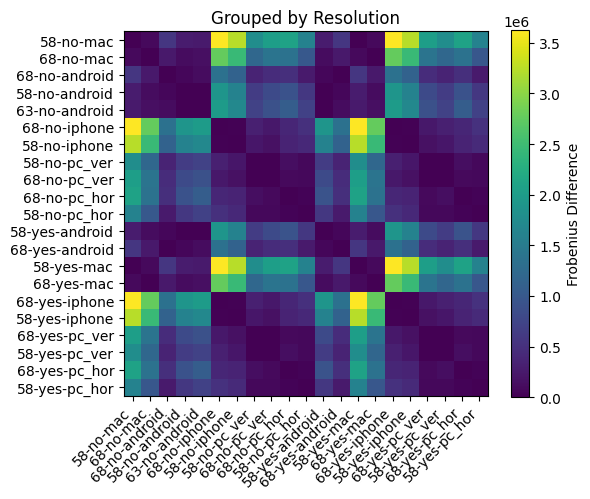

In [21]:
# Sort by Resolution

order = grouped_hierarchical_sort(dist_matrix, names, ['resolution'])
sorted_matrix, sorted_names = reorder(dist_matrix, names, order)
plot_heatmap(sorted_matrix, sorted_names, "Grouped by Resolution")


From this, we can derive the following properties about recording:

- Changing between dynamic resolution does NOT affect recording, so no need for a new transformation matrix
- Changing the IPD produces a minor change in transformation matrix, so a re-calculation is needed. However, in a punch, it may be okay to use the same transforamtion matrix.
- Switching recording devices DOES require a different transformation matrix

## Part 6: Aligning Video Frames and VR Data

All this is well and good... but what if we had an actual test situation where we had a video (which runs at a certain FPS) and positional data of objects per (Unity) frame. How do we align them?

To solve this, we need to be able to map each video frame to each Unity frame. This requires another method - a computer vision-based model - to do this. In particular, we will be using `easyocr` for this. You can find `easyocr` here: https://github.com/JaidedAI/EasyOCR

In [ ]:
import easyocr

# Helper function: is this an Integer?
def check_int(s:str):
    try: int(s)
    except ValueError: return False
    else: return True

# Initialize reader
reader = easyocr.Reader(['en'])

# Let's test this out with a simple test
# We have `./captures/mq3/63-no-android/`, which contains two files:
# - cube_video.mp4
# - cube_positions.csv
# We need to look at cube_video.mp4, and be able to extract frames from them. Is this possible?

# Initialize capture
ocr_trial_dir = os.path.join('.','captures','mq3','63-no-android')
cap = cv2.VideoCapture(os.path.join(ocr_trial_dir,'cube_video.mp4'))
if not cap.isOpened():
    raise ValueError("Could not open video.")

# Get `n` number of frames at random
nframes = 10
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
idxs = np.linspace(0, frame_count - 1, nframes, dtype=int)

# Iterate through capture to get frames
ocr_outdir = mkdirs(os.path.join(ocr_trial_dir, 'ocr_debug'))
ocr_threshold = 125
ocr_frames = []
for idx in idxs:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ok, frame = cap.read()
    if ok:
        # Conduct ocr operation
        h, w = frame.shape[:2]
        crop_h = int(h * 0.25)
        crop_w = int(w * 0.25)
        crop = frame[0:crop_h, 0:crop_w]
        grayscale = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        thr = cv2.threshold(grayscale, ocr_threshold, 255, cv2.THRESH_BINARY)[1]
        screen_text = reader.readtext(thr)
        # Save grayscale, threshold, and record
        conf_text = screen_text[0][1]
        ocr_frames.append({'frame_index':idx, 'text':conf_text})
        cv2.imwrite(os.path.join(ocr_outdir, f"{idx}_crop.jpg"), crop)
        cv2.imwrite(os.path.join(ocr_outdir, f"{idx}_grayscale.jpg"), grayscale)
        cv2.imwrite(os.path.join(ocr_outdir, f"{idx}_threshold.jpg"), thr)
ocr_df = pd.DataFrame(ocr_frames)
ocr_df.to_csv(os.path.join(ocr_outdir, 'ocr_debug.csv'), index=False)


## Final Remarks

This notebook covers the following topics:

1. Extracting trial directories from a root directory
2. Extracting frames from a video
3. Template-Matching
4. Identifying screen mappings

This notebook merely summarizes these functions. A more generic implementation of this idea can be found in `main.py`.

In [ ]:
def find_template_match(
    frame, 
    frame_filename,
    template_filename, 
    min_size=10, 
    max_size=50, 
        delta_size=5, 
        thresh=0.9,
        draw_bbox=False,
        draw_centers=True,
        bbox_color=[0,255,255],
        bbox_thickness=1,
        verbose=False):
    
    # Load frame using opencv
    #frame = cv2.imread(frame_filename)
    
    # Load template using opencv
    template_all = cv2.imread(template_filename, cv2.IMREAD_UNCHANGED)
    # Prep boxes list
    boxes = []
    # Iterate through possible sizes of the template, upwards to half of the size
    for p in np.arange(min_size, max_size, delta_size):
        # Resize the frame
        template_resize = cv2.resize(template_all, (p,p))
        # Get particular attributes of the image itself. 
        # We assume transparency, so we have to separate alpha from bgr
        template = template_resize[:,:,0:3]
        alpha = template_resize[:,:,3]
        alpha = cv2.merge([alpha,alpha,alpha])
        # get the width and height of the template
        h,w = template.shape[:2]
        # Prepare possible locations where the template matches
        loc = []
        # Find those matches.
        res = cv2.matchTemplate(
            frame,
            template,
            cv2.TM_CCORR_NORMED,
            mask=alpha
        )
        # threshold by a 
        loc = np.where(res >= thresh)
        if len(loc) > 0:
            for pt in zip(*loc[::-1]):
                boxes.append((pt[0],pt[1],pt[0]+w,pt[1]+h, pt[0]+(w/2), pt[1]+(h/2)))

    
    centers = []
    for (x1, y1, x2, y2, cx, cy) in boxes:
        #result = cv2.rectangle(result, (x1, y1), (x2, y2), bbox_color, bbox_thickness)
        centers.append([cx,cy])

    mean_center = np.mean(centers, axis=0)
    median_center = np.median(centers, axis=0)
    result = None
    
    if verbose:
        print(f"ESTIMATED MEAN POSITION: {mean_center}")
        print(f"ESTIMATED MEDIAN POSITION: {median_center}")
    
    if draw_bbox or draw_centers:
        result = frame.copy()
        if draw_bbox:
             for (x1, y1, x2, y2, cx, cy) in boxes:
                 result = cv2.rectangle(result, (x1, y1), (x2, y2), bbox_color, bbox_thickness)
        if draw_centers:
            result = cv2.drawMarker(result, (int(mean_center[0]), int(mean_center[1])), (0,255,255),cv2.MARKER_CROSS,20,2)
            result = cv2.drawMarker(result, (int(median_center[0]), int(median_center[1])), (255,255,0),cv2.MARKER_TILTED_CROSS,20,2)

        # Save resulting image
        frame_file_seperated, _ = os.path.splitext(frame_filename)
        result_path =  frame_file_seperated + "_matched" + ".jpg"
        cv2.imwrite(result_path, result)
    
    return mean_center, median_center, result

In [91]:
_TEMPLATE = './anchor.png'
last_centers = [find_template_match(f['frame'], f['filepath'], _TEMPLATE, verbose=True) for t in trials for f in t['frames']]

ESTIMATED MEAN POSITION: [1321.76750616  736.8644771 ]
ESTIMATED MEDIAN POSITION: [1322.  737.]
ESTIMATED MEAN POSITION: [1518.1938669   539.80674534]
ESTIMATED MEDIAN POSITION: [1518.5  539.5]
ESTIMATED MEAN POSITION: [1124.56738807  539.74867236]
ESTIMATED MEDIAN POSITION: [1124.5  539.5]
ESTIMATED MEAN POSITION: [1124.51453011  933.72879524]
ESTIMATED MEDIAN POSITION: [1124.5  934. ]
ESTIMATED MEAN POSITION: [1519.66681068  932.15324166]
ESTIMATED MEDIAN POSITION: [1519.5  932. ]
ESTIMATED MEAN POSITION: [1896.29746234  736.56722075]
ESTIMATED MEDIAN POSITION: [1896.5  736.5]
ESTIMATED MEAN POSITION: [1321.8775154   162.05283403]
ESTIMATED MEDIAN POSITION: [1322.  162.]
ESTIMATED MEAN POSITION: [746.99840217 736.55377871]
ESTIMATED MEDIAN POSITION: [747.  736.5]
ESTIMATED MEAN POSITION: [1321.86441881 1311.46223386]
ESTIMATED MEDIAN POSITION: [1322.  1311.5]
ESTIMATED MEAN POSITION: [1321.54794393  736.77133692]
ESTIMATED MEDIAN POSITION: [1322.   736.5]
ESTIMATED MEAN POSITION: [64